In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

import itertools

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

In [4]:
X_train = X_train / 255.0
test = test / 255.0

In [5]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [6]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [7]:
random_seed = 2

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

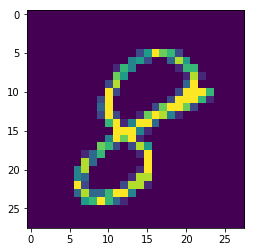

In [9]:
g = plt.imshow(X_train[0][:,:,0])

In [10]:
def prepare_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    
    return model

In [19]:
def train_model(X_train, Y_train, X_val, Y_val, optimizer, loss, epochs, batch_size):
    
    model = prepare_model()
    
    model.compile(optimizer = optimizer ,loss = loss, metrics=["accuracy"])
       
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False, 
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False)

    datagen.fit(X_train)
    
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size)

    return model, history.history['val_acc'][epochs-1]
    

In [20]:
def make_submission(predictions):
    predictions = np.argmax(predictions,axis = 1)
    predictions = pd.Series(predictions,name="Label")
    submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),predictions],axis = 1)
    submission.to_csv("submission_cnn.csv",index=False)

In [27]:
optimizers = ['SGD', 'RMSProp', 'Adagrad']
losses = ['categorical_crossentropy', 'categorical_hinge', 'mean_squared_error']
batch_sizes = [32, 64]
epochs = 10

In [29]:
best_model = None
best_score = 0
best_optimizer = None
best_loss = 0
best_epochs = 0
best_batch_size = 0
hyperparameters = list(itertools.product(optimizers,losses, batch_sizes))
i = 0
for optimizer, loss, batch_size in hyperparameters:
    i += 1
    print('====================================================')
    print('=================Iteration %2d of %d=================' % (i , len(hyperparameters)))
    print('=================Training with optimizer=%s, loss=%s, epochs=%d, batch_size=%d================' % (optimizer, loss, epochs, batch_size))
    print('====================================================')
    model, score = train_model(X_train, Y_train, X_val, Y_val, optimizer, loss, epochs, batch_size)
    if score > best_score:
        best_score = score
        best_model = model
        best_optimizer = optimizer
        best_loss = loss
        best_epochs = epochs
        best_batch_size = batch_size

print('=======================================')
print('=================Done!=================')
print('Best model: optimizer=%s, loss=%s, epochs=%d, batch_size=%d, val_acc=%f' % (best_optimizer, best_loss, best_epochs, best_batch_size, best_score))

=================Iteration  1 of 18=================
=================Training with optimizer=SGD, loss=categorical_crossentropy, epochs=10, batch_size=32================
Epoch 1/10
 - 15s - loss: 1.3603 - acc: 0.5264 - val_loss: 0.2084 - val_acc: 0.9379
Epoch 2/10
 - 13s - loss: 0.4202 - acc: 0.8666 - val_loss: 0.1172 - val_acc: 0.9660
Epoch 3/10
 - 14s - loss: 0.2826 - acc: 0.9126 - val_loss: 0.0852 - val_acc: 0.9743
Epoch 4/10
 - 13s - loss: 0.2243 - acc: 0.9316 - val_loss: 0.0723 - val_acc: 0.9779
Epoch 5/10
 - 13s - loss: 0.1950 - acc: 0.9395 - val_loss: 0.0687 - val_acc: 0.9793
Epoch 6/10
 - 13s - loss: 0.1730 - acc: 0.9471 - val_loss: 0.0606 - val_acc: 0.9805
Epoch 7/10
 - 13s - loss: 0.1587 - acc: 0.9514 - val_loss: 0.0535 - val_acc: 0.9860
Epoch 8/10
 - 13s - loss: 0.1440 - acc: 0.9567 - val_loss: 0.0478 - val_acc: 0.9860
Epoch 9/10
 - 13s - loss: 0.1345 - acc: 0.9594 - val_loss: 0.0439 - val_acc: 0.9864
Epoch 10/10
 - 13s - loss: 0.1238 - acc: 0.9609 - val_loss: 0.0415 - val_

In [31]:
epochs = 20
print('====================================================')
print('===============Training with optimizer=%s, loss=%s, epochs=%d, batch_size=%d==============' % (best_optimizer, best_loss, epochs, best_batch_size))
print('====================================================')
model, score = train_model(X_train, Y_train, X_val, Y_val, best_optimizer, best_loss, epochs, best_batch_size)
print('Best model retrained: optimizer=%s, loss=%s, epochs=%d, batch_size=%d, val_acc=%f' % (best_optimizer, best_loss, epochs, best_batch_size, score))

===============Training with optimizer=RMSProp, loss=categorical_crossentropy, epochs=20, batch_size=64==============
Epoch 1/20
 - 16s - loss: 0.3738 - acc: 0.8797 - val_loss: 0.0664 - val_acc: 0.9800
Epoch 2/20
 - 11s - loss: 0.1194 - acc: 0.9650 - val_loss: 0.0535 - val_acc: 0.9850
Epoch 3/20
 - 11s - loss: 0.0907 - acc: 0.9732 - val_loss: 0.0307 - val_acc: 0.9912
Epoch 4/20
 - 12s - loss: 0.0832 - acc: 0.9762 - val_loss: 0.0356 - val_acc: 0.9876
Epoch 5/20
 - 11s - loss: 0.0771 - acc: 0.9785 - val_loss: 0.0256 - val_acc: 0.9929
Epoch 6/20
 - 11s - loss: 0.0717 - acc: 0.9796 - val_loss: 0.0412 - val_acc: 0.9883
Epoch 7/20
 - 11s - loss: 0.0683 - acc: 0.9813 - val_loss: 0.0271 - val_acc: 0.9912
Epoch 8/20
 - 11s - loss: 0.0679 - acc: 0.9808 - val_loss: 0.0278 - val_acc: 0.9921
Epoch 9/20
 - 11s - loss: 0.0700 - acc: 0.9799 - val_loss: 0.0426 - val_acc: 0.9886
Epoch 10/20
 - 11s - loss: 0.0691 - acc: 0.9819 - val_loss: 0.0299 - val_acc: 0.9921
Epoch 11/20
 - 11s - loss: 0.0702 - acc: 

In [33]:
predictions = model.predict(test)

In [34]:
make_submission(predictions)